# Annotation Generator Using Sobel + Contours

In [ ]:
# Mount Drive Folder to Colab
from google.colab import drive
drive.mount("/content/gdrive")

!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/projects/opencv2_pj1
!ls

In [ ]:
# Libraries
import os
import numpy as np
import cv2 as cv
import shutil
import imutils
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
# Using OS dir

def show_images_from_folderby_osdir(image_data):
  try:
    # store_ospath = [os.path.join("sampleIMG", f) for f in image_data]
    store_ospath = []
    for f in image_data:
     file_path = os.path.join("sampleIMG", f)
     store_ospath.append(file_path)
    return store_ospath

  except FileNotFoundError:
    print("Invalid file or File not found")

In [ ]:
# Plotter

def plot_img(images, subTitle="None", labels=None, colors=None):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=( 7 , 5 ))

    if n == 1:
        axs = [axs]

    for j, image in enumerate(images):
        img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axs[j].imshow(img_rgb)
        axs[j].axis('off')
        axs[j].set_title(subTitle[j], fontsize=10, pad=10)

    legend_elements = [Patch(facecolor=color, edgecolor='none', label=label)
                      for label, color in zip(labels, colors)]

    fig.legend(handles=legend_elements,
              loc='center left', fontsize=6, handlelength=2.2, handleheight=0.8,
              bbox_to_anchor=(1.0, 0.46), borderpad=1.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# Edge detector

def annotated_sobel_segmentation(images, area_threshold=500 ):
  annotated_results = []
  for img in images:
    original = cv.imread(str(img))
    if original is None:
      print(f"Could not read image: {images}")
      continue

    gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)

    sobelx = cv.Sobel(blur, cv.CV_64F, 1, 0, ksize=3)
    sobely = cv.Sobel(blur, cv.CV_64F, 0, 1, ksize=3)
    edgexy = cv.magnitude(sobelx, sobely)
    sobelEdges = cv.convertScaleAbs(edgexy)

    _, thresh_img = cv.threshold(sobelEdges, 70, 255, cv.THRESH_BINARY)

    kernel = np.ones((4, 4), np.uint8)
    closed = cv.morphologyEx(thresh_img, cv.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv.findContours(closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    black_bg = np.zeros(original.shape, dtype=np.uint8)
    cv.drawContours(black_bg, contours, -1, (0, 155, 0), thickness=cv.FILLED)

    result = original.copy()
    for i, cnt in enumerate(contours):
      if cv.contourArea(cnt) < area_threshold:
        continue

      x, y, w, h = cv.boundingRect(cnt)
      cv.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 1)
      cv.drawContours(result, [cnt], -1, (0, 255, 0), thickness=cv.FILLED)
      cv.putText(
          result, f"Obj {i+1}", (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    images =[original, black_bg, result]
    labels=["Detected Areas", "Background"]
    subTitle=["Original", "Detected", "Result"]
    colors = ["#32CD32", 'black']

    plot_img(images, subTitle=subTitle, labels=labels, colors=colors)

    image_name = os.path.basename(img)
    annotated_results.append((image_name, result))

  # save_anotation(annotated_results)



In [ ]:
# To save Files
def save_anotation(annotated_results, save_dir="annotated images"):
  if os.path.exists(save_dir):
      shutil.rmtree(save_dir)
  os.makedirs(save_dir)

  for name, image in annotated_results:
      save_path = os.path.join(save_dir, name)
      cv.imwrite(save_path, image)
  print(f"Saved as {save_dir} folder")

---

# Result

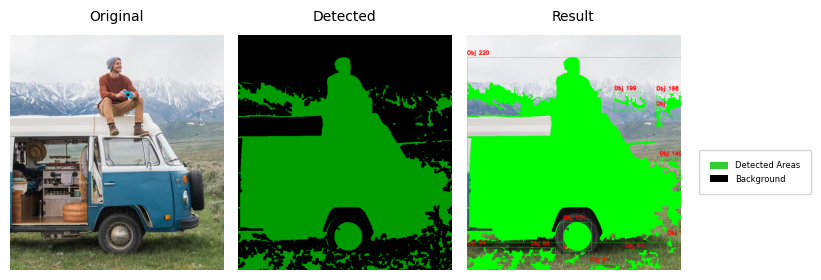

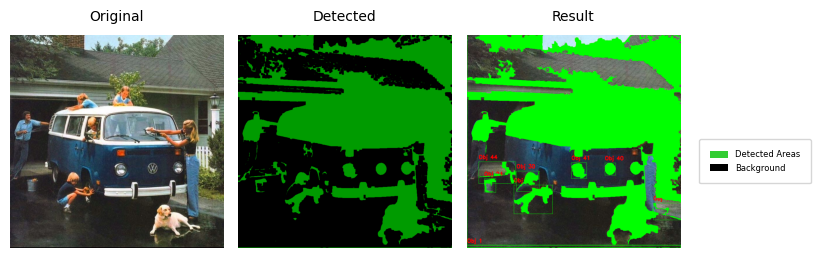

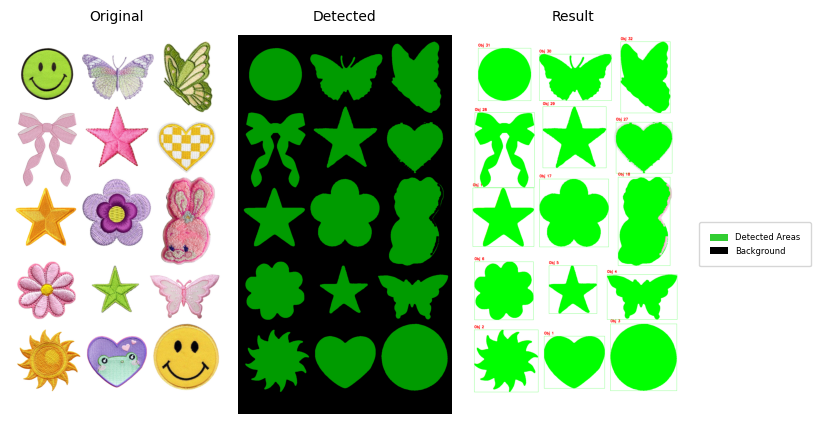

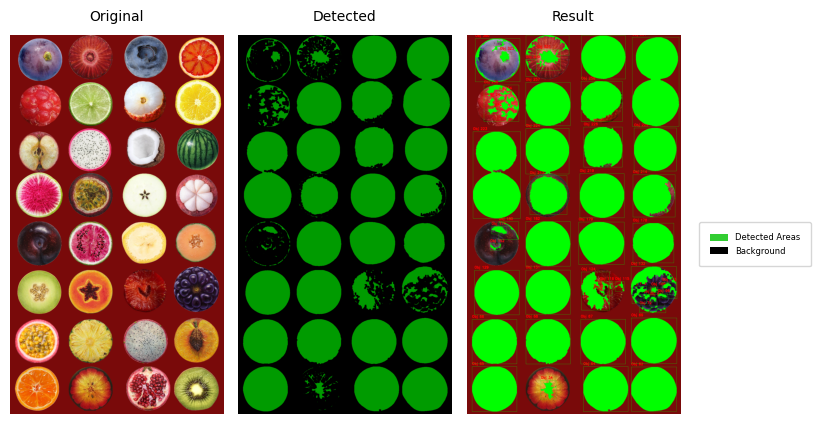

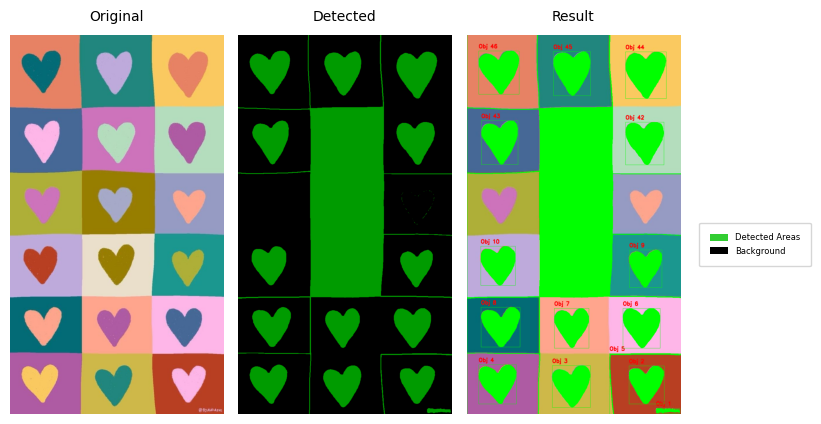

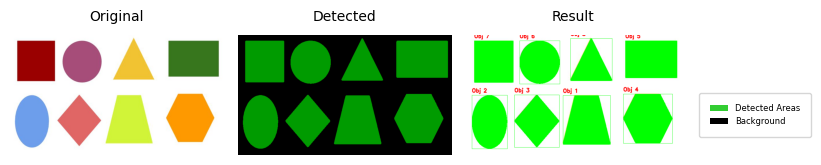

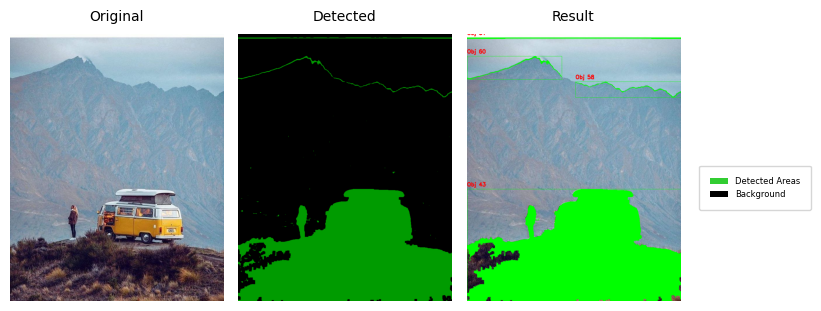

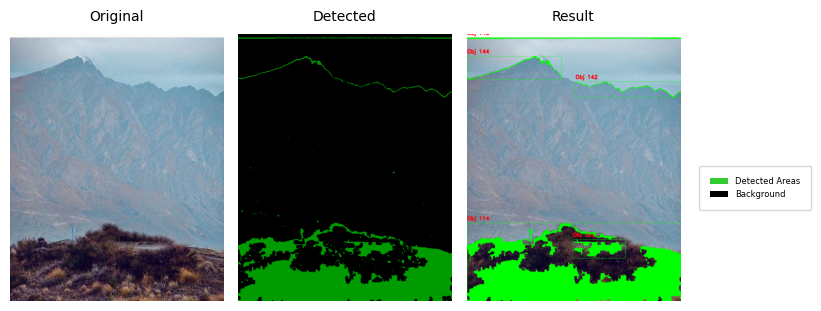

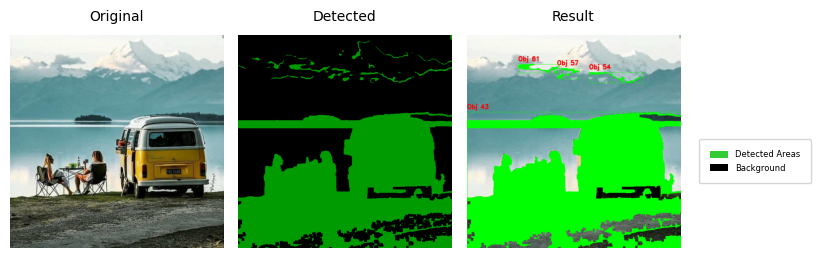

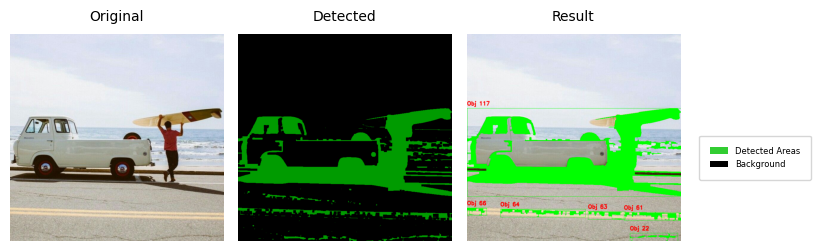

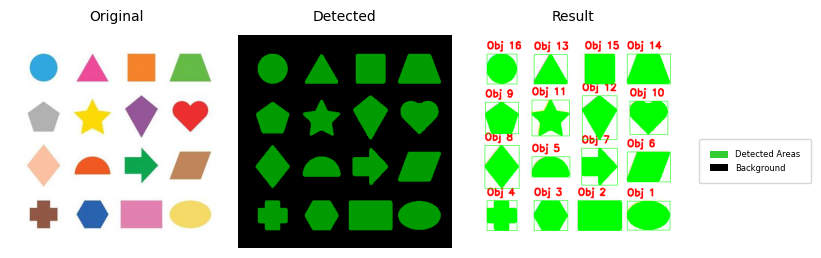

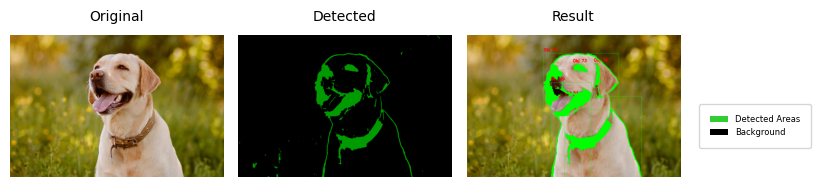

In [ ]:
if __name__ == "__main__":
  osdir = os.listdir("sampleIMG")
  images = [os.path.join("sampleIMG", file) for file in osdir if file.endswith(('.png', '.jpg', '.jpeg'))]

  annotated_sobel_segmentation(images, area_threshold=400)